# Age Classification through Face Recognition with Transfer Learning

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import random
import os
import sys
import shutil
from copy import deepcopy

sys.path +=["src"]
import preprocessing


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


d:\Anaconda3\envs\tf\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Global Variables (Data INPUT_PATHs)

In [5]:
INPUT_PATH = '../input'
#--------------------------
INPUT_TRAINING = INPUT_PATH+'/TRAINING'
INPUT_VALIDATION = INPUT_PATH+'/VALIDATION'
INPUT_TEST = INPUT_PATH+'/TEST'

train_dir = os.path.join(INPUT_PATH, 'TRAINING')
validation_dir = os.path.join(INPUT_PATH, 'VALIDATION')
test_dir = os.path.join(INPUT_PATH, 'TEST')


OUTPUT_PATH = 'output'
#--------------------------
OUTPUT_TRAINING = OUTPUT_PATH+'/training'
OUTPUT_TEST = OUTPUT_PATH+'/test'



We define the batch and image size we want to work with.

In [6]:
BATCH_SIZE = 16
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

# DATA PREPROCESSING

We used the following [data set](https://www.kaggle.com/datasets/frabbisw/facial-age) **"facial age"** containing 9778 images of people aged from 1 to 110. Based on its labeling, each picture is contained in a folder named as the label.

Since the dataset is not large enough to enable fine-prediction of age, we created classes/bins so that the numbers of elements belonging to each class would be balanced.

### Training/Validation/Test Split
To begin with, we had to create a split in Training, Validation and Test sets. 

Defining some useful functions, in order to manipulate files composing the dataset.

- Given a parent folder INPUT_PATH, extracts the INPUT_PATH of all files inside all subfolders. For each subfolder, a list is created such that the output is a list of lists: if a single list of INPUT_PATHs is required, optional flatting is possible.

In [30]:
get_img_path = preprocessing.get_img_path

- Move images (list of INPUT_PATHs required) to a destination folder.

In [31]:
move_imgs = preprocessing.move_imgs

- Given the file INPUT_PATHs list of all files contained in a folder, it shuffles the INPUT_PATH list and creates three other lists such that the split percentage is satisfied.

In [32]:
splitter = preprocessing.splitter

Creating the dataset split and moving images in the appropriate Training/Validation/Test folder. In our case, we opted for a 80/10/10 split.

In [33]:
labels = ['01','11','21','31','41','61']

# for a in labels: #UNCOMMENT TO RUN
   label_train = INPUT_TRAINING +'/' + a
   label_val = INPUT_VALIDATION +'/' + a
   label_test = INPUT_TEST +'/' + a

   # Creating splitting
   compilation = get_img_path(INPUT_PATH +'/' + a, flatten=True)
   train, val, test = splitter(compilation, train_split=0.8 , val_split=0.1, test_split=0.1)

   # Moving imgs to the right folder
   move_imgs(train,label_train)
   move_imgs(val,label_val)
   move_imgs(test,label_test)

IndentationError: unexpected indent (2502295623.py, line 4)

### Creating Tensorflow Datasets

Since we have built a structure of data in the file system as folders function as labels, we can use TF utility that allows creation of datasets based on folder structures.

In [34]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7824 files belonging to 6 classes.


In [35]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 977 files belonging to 6 classes.


In [36]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 977 files belonging to 6 classes.


[*CHECK*] Show the first nine images and labels from the training set:

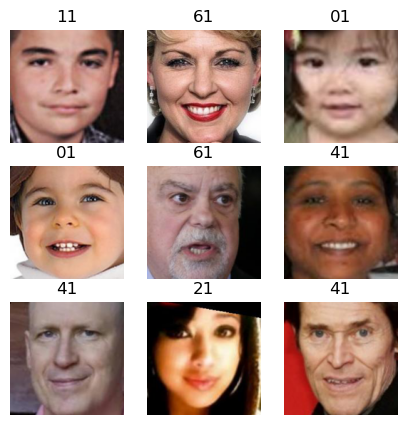

In [37]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# BUILDING THE BASE MODEL

## Generate Model (sufficient to run this cell. Anything below is just for explanatory purpose)

In [39]:
# Building my model class
def custom_model(img_shape: tuple[int, int, int], freeze_up_to : int | None = None,):
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    if freeze_up_to is not None:
        if freeze_up_to > len(base_model.layers):
            raise ValueError('Layers to freeze are more than layers available in base model')
        for layer in base_model.layers[:freeze_up_to]:
            layer.trainable = False
    else:
        base_model.trainable = True

    # Defining additional layers
    inputs = tf.keras.Input(shape=img_shape)
    data_augmentation = tf.keras.Sequential([
                                            tf.keras.layers.RandomFlip('horizontal'),
                                            tf.keras.layers.RandomRotation(0.2),
                                            ])
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    # Base Model goes here in-between (see below)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(6
                                         ,activation='softmax'
                                         #,kernel_regularizer=tf.keras.regularizers.l2(0.0001)
                                         ,kernel_initializer='glorot_uniform'    )
    
    # Putting all together to build the actual model
    inputs = tf.keras.Input(shape=img_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)    
    
    return model

model = custom_model(IMG_SHAPE)
model.compile()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### Use data augmentation

Artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

[*CHECK*] Let's repeatedly apply these layers to the same image and see the result.

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Loading Pre-Trained Model

Create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`.

Loading the pre-trained model MobileNetV2 on *Imagenet* dataset. By specifying the include_top=False argument, the model won't include the classification layers at the top, which allows for better feature extraction. 

In [12]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

### Rescale pixel values

We will download `tf.keras.applications.MobileNetV2` for use as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in our images are in `[0, 255]`. 
So we rescale them, using a preprocessing method included within the model.

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Step 1 - Feature extraction
We will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we add a classifier on top of it and train the top-level classifier.

#### Freeze the convolutional base

Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [29]:
base_model.trainable = False

#### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` with an output of 6, which is the number of layers. In particular, we use a SoftMax activation function since out task is to classify in more dimensions than 2.

In [31]:
prediction_layer = tf.keras.layers.Dense(6
                                         ,activation='softmax'
                                         #,kernel_regularizer=tf.keras.regularizers.l2(0.0001)
                                         ,kernel_initializer='glorot_uniform'    )

We now effectively build the model, adding the new layers on top.

In [32]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

Compile the model before training it. Since there are six non-one-hot encoded classes, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss.

In [34]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['SparseCategoricalAccuracy','Accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

## Step 2: Training with(out) FineTuning


### Without fine-tuning

In [26]:
initial_epochs = 1

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

489/489 [==============================] - 50s 95ms/step - loss: 1.6456 - sparse_categorical_accuracy: 0.3834 - Accuracy: 0.3834 - val_loss: 1.3189 - val_sparse_categorical_accuracy: 0.4719 - val_Accuracy: 0.4719


#### Save Learning Curves data

Let's save the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

In [ ]:
# ONLY FOR PIPELINE DEMONSTRATION -> WILL BE USED WHEN EXPERIMENTS ARE PERFORMED IN NEXT CHAPTER
# pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

### With Fine-Tuning

Unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, we should recompile the model (necessary for these changes to take effect), and resume training.

In [35]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


Compile the model

In [44]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['SparseCategoricalAccuracy', 'Accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

Train the model

In [45]:
epochs = 2


history_fine = model.fit(train_dataset,
                         epochs=epochs,
                         initial_epoch=history.epoch[-1]+1
                         ,validation_data=validation_dataset)

# model.save('Model/Best_FineTuned')

Epoch 2/2
489/489 [==============================] - 65s 123ms/step - loss: 0.9970 - sparse_categorical_accuracy: 0.5978 - Accuracy: 0.5978 - val_loss: 0.8910 - val_sparse_categorical_accuracy: 0.6510 - val_Accuracy: 0.6510


## Step 3: Model Evaluation

Let's verify the performance of out model on the Test Set.

In [46]:
loss, sparse, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

62/62 [==============================] - 4s 71ms/step - loss: 0.8660 - sparse_categorical_accuracy: 0.6469 - Accuracy: 0.6469
Test accuracy : 0.646878182888031


We create a dictionary with the results of training and validation and save it to a .csv file.

In [47]:
a = {"model":"Fine tuning model 300ep","loss": loss, "accuracy":accuracy, "sparse": sparse}
print(a)

# If to file:
# pd.DataFrame.from_dict(a,orient='index').to_csv('test_acc_fine_tuning.csv', index=True)

{'model': 'Fine tuning model 300ep', 'loss': 0.8659822344779968, 'accuracy': 0.646878182888031, 'sparse': 0.646878182888031}


# TRAINED MODELS & EXPERIMENTS

## Overview

Pre-trained base model MobileNet V2 further trained in the following ways:
1) Top Classificator only
2) Fine-tuning at layers [40, 64, 88, 100, 125, 137]
3) The whole model

for 20 and 300 epochs for each model-type.

We also tried to train a Progressively-Fine-tuned model (for every 2 epochs, one more fine-tunable layer is added to the training process); however, due to a mistake in the code the results were not as expected and there was no computational time to re-run it.

As a last step, considering the best model (Whole Net), we trained it for 300 epochs using 3 different learning rates [0.0001, 0.001, 0.01] to determine the best learning rate for the task.

### Top Classificator Only - Learning Pipeline
We freeze the whole base model and train only the classificator on top.


In [38]:
to_file = False # Set to True to save data

# epochs = [20, 300]
epochs = [300]
freeze_up_to = 154
learning_rate = 0.0001

model = custom_model(IMG_SHAPE, freeze_up_to=freeze_up_to)

for epochs in epochs:
    training_metrics = {'loss': [], 'sparse_accuracy': [], 'accuracy': []}
    validation_metrics = {'val_loss': [], 'val_sparse_accuracy': [], 'val_accuracy': []}

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['SparseCategoricalAccuracy', 'Accuracy'])
    
    history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)
    
    # Model evaluation
    test_loss, test_sparse_accuracy, test_accuracy = model.evaluate(test_dataset)
    
    # Store data
    training_metrics['loss'] = history.history['loss']
    training_metrics['sparse_accuracy'] = history.history['sparse_categorical_accuracy']
    training_metrics['accuracy'] = history.history['Accuracy']

    validation_metrics['val_loss'] = history.history['val_loss']
    validation_metrics['val_sparse_accuracy'] = history.history['val_sparse_categorical_accuracy']
    validation_metrics['val_accuracy'] = history.history['val_Accuracy']

    
    
    evaluation = {"model": f"Classificator_{epochs}epochs","loss": test_loss, "accuracy": test_accuracy, "sparse": test_sparse_accuracy}

    if to_file is True:
        training_validation_metrics = {**training_metrics, **validation_metrics}
        pd.DataFrame.from_dict(training_validation_metrics,orient='index').to_csv(f'{OUTPUT_TRAINING}/Classificator_{epochs}epochs.csv', index=True)

        pd.DataFrame.from_dict(evaluation,orient='index').to_csv(f'{OUTPUT_TEST}/test_Classificator_{epochs}epochs.csv', index=True)

        
    

Epoch 1/300
489/489 [==============================] - 47s 91ms/step - loss: 1.7071 - sparse_categorical_accuracy: 0.3593 - Accuracy: 0.3593 - val_loss: 1.3049 - val_sparse_categorical_accuracy: 0.4995 - val_Accuracy: 0.4995
Epoch 2/300
210/489 [===========>..................] - ETA: 22s - loss: 1.3817 - sparse_categorical_accuracy: 0.4664 - Accuracy: 0.4664

: 

### Whole Model - Learning Pipeline
We allow the whole base model + classificator on top to be trained.


In [ ]:
to_file = False # Set to True to save data

epochs = [20, 300]
freeze_up_to = None # Difference with Classificator only
learning_rate = 0.0001

model = custom_model(IMG_SHAPE, freeze_up_to=freeze_up_to)

for epochs in epochs:
    training_metrics = {'loss': [], 'sparse_accuracy': [], 'accuracy': []}
    validation_metrics = {'val_loss': [], 'val_sparse_accuracy': [], 'val_accuracy': []}

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['SparseCategoricalAccuracy', 'Accuracy'])
    history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)
    
    # Model evaluation
    test_loss, test_sparse_accuracy, test_accuracy = model.evaluate(test_dataset)

    # Store data
    training_metrics['loss'] = history.history['loss']
    training_metrics['sparse_accuracy'] = history.history['sparse_categorical_accuracy']
    training_metrics['accuracy'] = history.history['Accuracy']

    validation_metrics['val_loss'] = history.history['val_loss']
    validation_metrics['val_sparse_accuracy'] = history.history['val_sparse_categorical_accuracy']
    validation_metrics['val_accuracy'] = history.history['val_Accuracy']

    
    evaluation = {"model":f"Whole_{epochs}epochs","loss": loss, "accuracy":accuracy, "sparse": sparse}

    if to_file is True:
        training_validation_metrics = {**training_metrics, **validation_metrics}
        pd.DataFrame.from_dict(training_validation_metrics,orient='index').to_csv(f'{OUTPUT_TRAINING}/Whole_{epochs}epochs.csv', index=True)

        pd.DataFrame.from_dict(evaluation,orient='index').to_csv(f'{OUTPUT_TEST}/test_Whole_{epochs}epochs.csv', index=True)
    

### Progressive Fine-tuning of all layers - Learning Pipeline

In [40]:
to_file = False # Set to True to save data
freeze_up_to = [40, 64, 88, 100, 125, 137]
epochs = [20, 300]
learning_rate = 0.0001

def get_k(total_epochs):
    return 5 if total_epochs == 20 else 50 if total_epochs == 500 else total_epochs // 4

for total_epochs in epochs:
    for n in freeze_up_to:
        k = get_k(total_epochs)
        
        training_metrics = {'loss': [], 'sparse_accuracy': [], 'accuracy': []}
        validation_metrics = {'val_loss': [], 'val_sparse_accuracy': [], 'val_accuracy': []}

        # First stage: Train only the top layer
        model = custom_model(IMG_SHAPE, 154)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['SparseCategoricalAccuracy','Accuracy'])
        history1 = model.fit(train_dataset,
                            epochs=k,
                            validation_data=validation_dataset)

        # Second stage: Unfreeze additional layers
        for layer in model.layers[n:154]:
            layer.trainable = True
        
        # Recompile the model with the same parameters
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['SparseCategoricalAccuracy','Accuracy'])
        
        history2 = model.fit(train_dataset,
                            epochs=total_epochs-k,
                            initial_epoch=k,  # Start from where we left off
                            validation_data=validation_dataset)

        # Combine metrics from both stages
        for metric in training_metrics.keys():
            training_metrics[metric] = history1.history[metric] + history2.history[metric]
            validation_metrics['val_' + metric] = history1.history['val_' + metric] + history2.history['val_' + metric]

        loss, accuracy, sparse = model.evaluate(test_dataset)
        evaluation = {"model": f'Finetuned_layer{n}_{total_epochs}epochs', "loss": loss, "accuracy": accuracy, "sparse": sparse}

        if to_file:
            training_validation_metrics = {**training_metrics, **validation_metrics}
            pd.DataFrame.from_dict(training_validation_metrics,orient='index').to_csv(f'{OUTPUT_TRAINING}/Finetuned_layer{n}_{total_epochs}epochs.csv', index=True)
            
            pd.DataFrame.from_dict(evaluation,orient='index').to_csv(f'{OUTPUT_TEST}/test_Finetuned_layer{n}_{total_epochs}epochs.csv', index=True)

Epoch 1/5
313/489 [==================>...........] - ETA: 14s - loss: 1.8058 - sparse_categorical_accuracy: 0.3219 - Accuracy: 0.3219

: 

# Results and Conclusions

Load data produced by models and will plot it.

In [18]:
# 300 epochs
FineTuned_300 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer100_300epochs.csv',delimiter=",")
Whole_300 = pd.read_csv(OUTPUT_TRAINING+'/'+'Whole_300epochs.csv',delimiter=",")
Classificator_300 = pd.read_csv(OUTPUT_TRAINING+'/'+'Classificator_300epochs.csv',delimiter=",") 


# 20 epochs (Different Finetune starting layer)
FineTuned_20_100 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer100_20epochs.csv',delimiter=",")
FineTuned_20_40 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer40_20epochs.csv',delimiter=",")
FineTuned_20_64 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer64_20epochs.csv',delimiter=",")
FineTuned_20_88 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer88_20epochs.csv',delimiter=",")
FineTuned_20_125 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer125_20epochs.csv',delimiter=",")
FineTuned_20_137 = pd.read_csv(OUTPUT_TRAINING+'/'+'FineTuned_layer137_20epochs.csv',delimiter=",")
Whole_20 = pd.read_csv(OUTPUT_TRAINING+'/'+'Whole_20epochs.csv',delimiter=",")
Classificator_20 = pd.read_csv(OUTPUT_TRAINING+'/'+'Classificator_20epochs.csv',delimiter=",")


# Studying Learning rate (300 epochs)
All_lr_0_01 = pd.read_csv(OUTPUT_TRAINING+'/'+'Whole_300epochs_lr01.csv',delimiter=",")
All_lr_0_001 = pd.read_csv(OUTPUT_TRAINING+'/'+'Whole_300epochs_lr001.csv',delimiter=",")



## Models on 20 epochs

### Top layer classificator only

Select start and end value to plot data.

In [19]:
alpha = min([min(Classificator_20['val_Accuracy']),min(Classificator_20['Accuracy'])])
beta = max([max(Classificator_20['val_Accuracy']),max(Classificator_20['Accuracy'])])

alpha1 = min([min(Classificator_20['loss']),min(Classificator_20['val_loss'])])
beta1 = max([max(Classificator_20['loss']),max(Classificator_20['val_loss'])])

Plot Training and Validation curves of accuracy and loss.

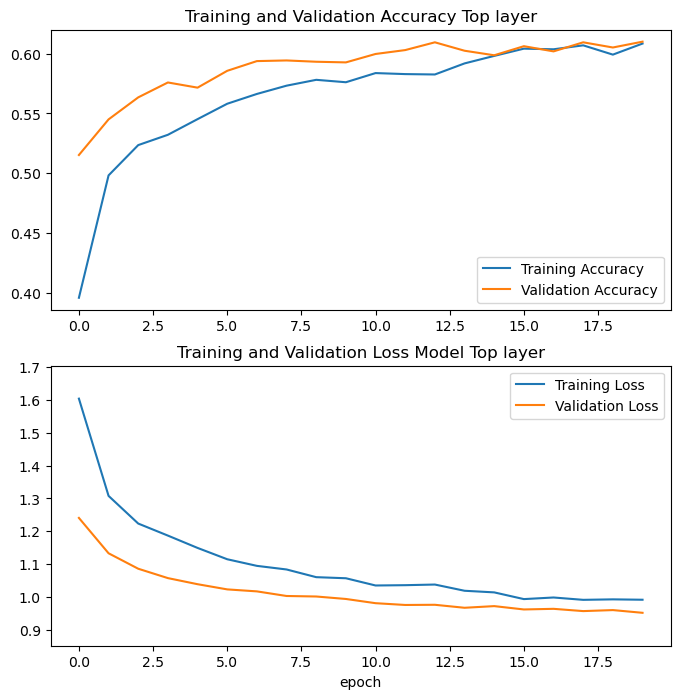

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Classificator_20['Accuracy'], label='Training Accuracy')
plt.plot(Classificator_20['val_Accuracy'], label='Validation Accuracy')
plt.ylim([alpha-0.01, beta+0.01])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Top layer')

plt.subplot(2, 1, 2)
plt.plot(Classificator_20['loss'], label='Training Loss')
plt.plot(Classificator_20['val_loss'], label='Validation Loss')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Model Top layer')
plt.xlabel('epoch')
plt.show()

**Note:** We see a much slower learning once the 70% accuracy is reached. Notice also how the validation curve is above the Training one: this is most likely due to fluctuations in prediction.

### Fine-tuning 56 layers (from the 10th epoch onwards)

---



In [21]:
alpha = min([min(FineTuned_20_100['val_Accuracy']),min(FineTuned_20_100['Accuracy'])])
beta = max([max(FineTuned_20_100['val_Accuracy']),max(FineTuned_20_100['Accuracy'])])

alpha1 = min([min(FineTuned_20_100['loss']),min(FineTuned_20_100['val_loss'])])
beta1 = max([max(FineTuned_20_100['loss']),max(FineTuned_20_100['val_loss'])])

disc = 10

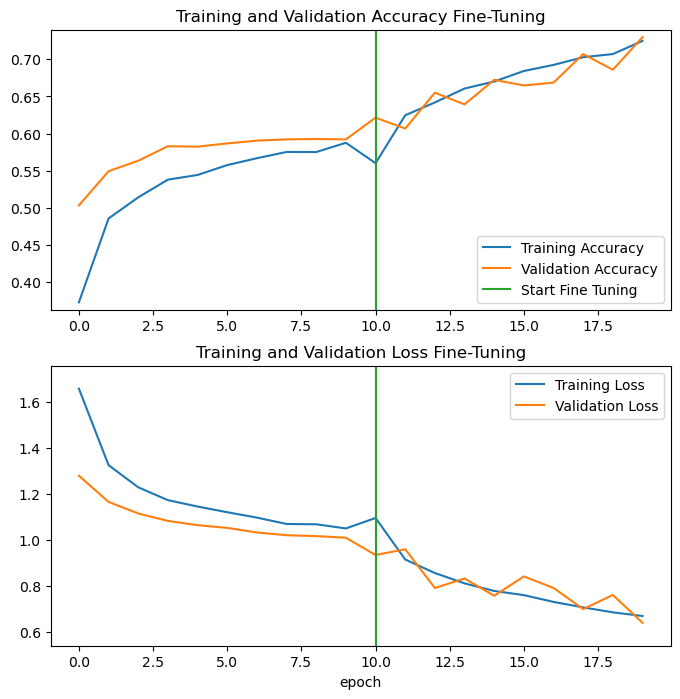

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(FineTuned_20_100['Accuracy'], label='Training Accuracy')
plt.plot(FineTuned_20_100['val_Accuracy'], label='Validation Accuracy')
plt.ylim([alpha-0.01, beta+0.01])
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Fine-Tuning')

plt.subplot(2, 1, 2)
plt.plot(FineTuned_20_100['loss'], label='Training Loss')
plt.plot(FineTuned_20_100['val_loss'], label='Validation Loss')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss Fine-Tuning')
plt.xlabel('epoch')
plt.show()

### Whole net

**Note:** We see how the trend of slowed learning is broken by fine-tuning, allowing for faster and more potential learning before a higher plateau is reached (see 300 epochs). At 20th epoch the learning process is clearly not over and could go on, which is why we then trained for 300 epochs to see how this trend develops going on in time.

In [ ]:
alpha = min([min(Whole_20['val_Accuracy']),min(Whole_20['Accuracy'])])
beta = max([max(Whole_20['val_Accuracy']),max(Whole_20['Accuracy'])])

alpha1 = min([min(Whole_20['loss']),min(Whole_20['val_loss'])])
beta1 = max([max(Whole_20['loss']),max(Whole_20['val_loss'])])

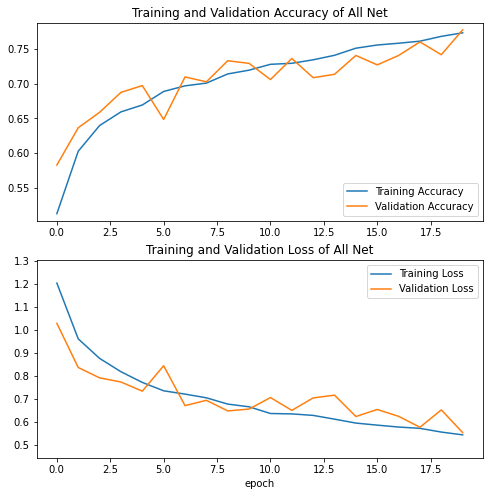

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_20['Accuracy'], label='Training Accuracy')
plt.plot(Whole_20['val_Accuracy'], label='Validation Accuracy')
plt.ylim([alpha-0.01, beta+0.01])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of All Net')

plt.subplot(2, 1, 2)
plt.plot(Whole_20['loss'], label='Training Loss')
plt.plot(Whole_20['val_loss'], label='Validation Loss')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of All Net')
plt.xlabel('epoch')
plt.show()

**Note:** Just with 20 epochs, we can see how training the whole network proves to be beneficial: accuracies reached are much higher. 

### Graphs with all models (Training)

Let's compare the 3 models with each other, by plotting them on the same plot.

In [33]:
alpha = min([min(Whole_20['Accuracy']),min(FineTuned_20_100['Accuracy']),min(Classificator_20['Accuracy'])])
beta = max([max(Whole_20['Accuracy']),max(FineTuned_20_100['Accuracy']),max(Classificator_20['Accuracy'])])

alpha1 = min([min(Whole_20['loss']),min(FineTuned_20_100['loss']),min(Classificator_20['loss'])])
beta1 = max([max(Whole_20['loss']),max(FineTuned_20_100['loss']),max(Classificator_20['loss'])])

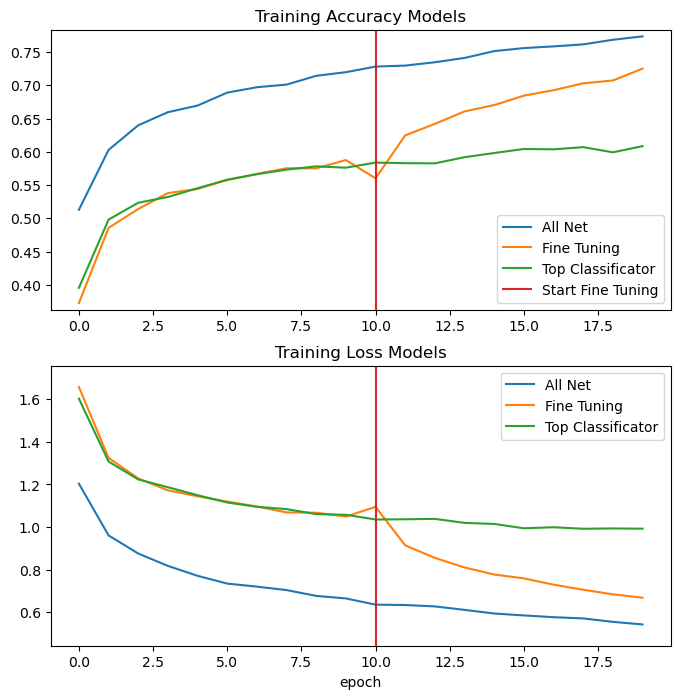

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_20['Accuracy'], label='All Net')
plt.plot(FineTuned_20_100['Accuracy'], label='Fine Tuning')
plt.plot(Classificator_20['Accuracy'], label='Top Classificator')
plt.ylim([alpha-0.01, beta+0.01])
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy Models')

plt.subplot(2, 1, 2)
plt.plot(Whole_20['loss'], label='All Net')
plt.plot(FineTuned_20_100['loss'], label='Fine Tuning')
plt.plot(Classificator_20['loss'], label='Top Classificator')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training Loss Models')
plt.xlabel('epoch')
plt.show()

**CONCLUSION:** Training the whole net seems to provide much more benefit than keeping weights freezed.

One hypothesis might be the following:

Since the whole network is initialized to Imagenet weights, it starts out the training process in a favorable point of the parameters' hyperspace. Furthermore, the same low learning rate has been used to train all models: lower learning rates should make it difficult for backpropagation to reach deeper layers (ie. Vanishing Gradients phenomena) to effectively modify the core structure of the model. What we are left with is an effective fine-tuning that has a greater effect on outer layers but is still valuable to tune middle layers for the specific task of face recognition. 

### Fine-Tuning from starting from different layers

Several models have been trained commencing fine-tuning from different layers after the top-classifier has been trained for 10 epochs. What is expected is that the more layers we train, the higher the accuracy.

In [23]:
alpha = min([min(FineTuned_20_40['Accuracy']),min(FineTuned_20_64['Accuracy']),min(FineTuned_20_125['Accuracy']), min(Whole_20['Accuracy'])])
beta = max([max(Whole_20['Accuracy']),max(FineTuned_20_40['Accuracy']),max(FineTuned_20_64['Accuracy']), max(FineTuned_20_125['Accuracy'])])

alpha1 =min([min(FineTuned_20_40['loss']),min(FineTuned_20_64['loss']),min(FineTuned_20_125['loss']), min(Whole_20['loss'])])
beta1 = max([max(Whole_20['loss']),max(FineTuned_20_40['loss']),max(FineTuned_20_64['loss']), max(FineTuned_20_125['loss'])])

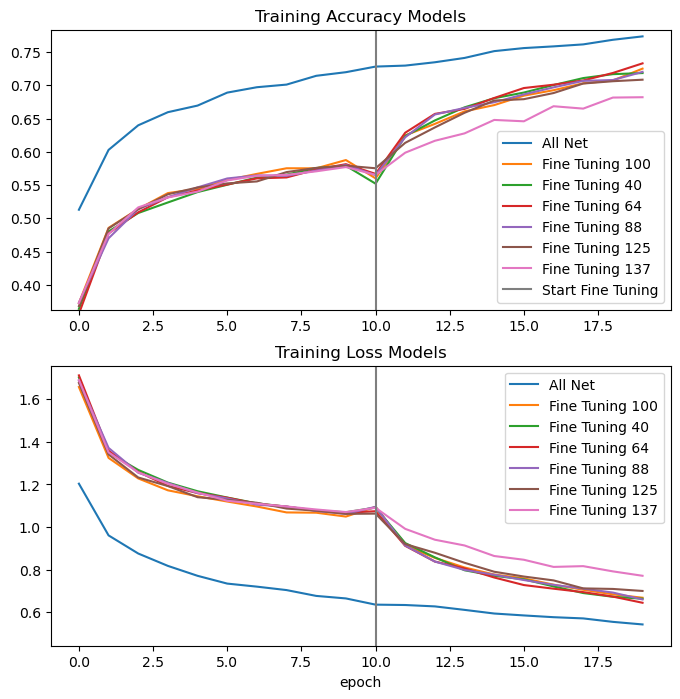

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_20['Accuracy'], label='All Net')
plt.plot(FineTuned_20_100['Accuracy'], label='Fine Tuning 100')
plt.plot(FineTuned_20_40['Accuracy'], label='Fine Tuning 40')
plt.plot(FineTuned_20_64['Accuracy'], label='Fine Tuning 64')
plt.plot(FineTuned_20_88['Accuracy'], label='Fine Tuning 88')
plt.plot(FineTuned_20_125['Accuracy'], label='Fine Tuning 125')
plt.plot(FineTuned_20_137['Accuracy'], label='Fine Tuning 137')
plt.ylim([alpha-0.01, beta+0.01])
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy Models')

plt.subplot(2, 1, 2)
plt.plot(Whole_20['loss'], label='All Net')
plt.plot(FineTuned_20_100['loss'], label='Fine Tuning 100')
plt.plot(FineTuned_20_40['loss'], label='Fine Tuning 40')
plt.plot(FineTuned_20_64['loss'], label='Fine Tuning 64')
plt.plot(FineTuned_20_88['loss'], label='Fine Tuning 88')
plt.plot(FineTuned_20_125['loss'], label='Fine Tuning 125')
plt.plot(FineTuned_20_137['loss'], label='Fine Tuning 137')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training Loss Models')
plt.xlabel('epoch')
plt.show()

**Conclusion:** Before the fine-tuning process we can clearly see how the classifier's training is, apart from fluctuations, the same. When fine-tuning is started, curves start to separate from each other: we can clealry how the shallowest fine-tuned model has the highest loss. The others seem to follow the same trend, but it is probably due to not having enough epochs to train deeper layers in order to achieve higher accuracies. It is also possible to notice that the fine-tuned curves have the same trend as the whole network, suggesting the idea that the whole network itself is going through a smooth fine-tuning process that has access to all layers.

### Graphs with all models (Validation)

Let's plot the validation metrics now.

In [24]:
alpha = min([min(Whole_20['val_Accuracy']),min(FineTuned_20_100['val_Accuracy']),min(Classificator_20['val_Accuracy'])])
beta = max([max(Whole_20['val_Accuracy']),max(FineTuned_20_100['val_Accuracy']),max(Classificator_20['val_Accuracy'])])

alpha1 = min([min(Whole_20['val_loss']),min(FineTuned_20_100['val_loss']),min(Classificator_20['val_loss'])])
beta1 = max([max(Whole_20['val_loss']),max(FineTuned_20_100['val_loss']),max(Classificator_20['val_loss'])])

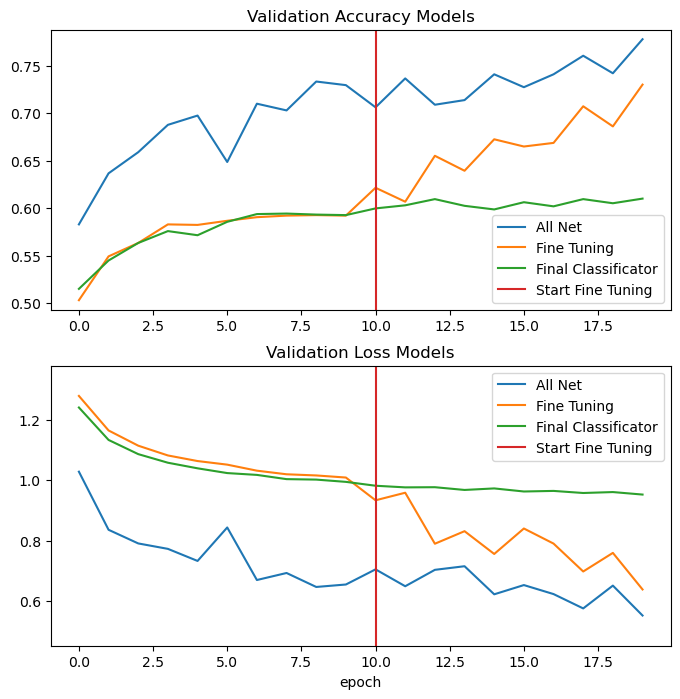

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_20['val_Accuracy'], label='All Net')
plt.plot(FineTuned_20_100['val_Accuracy'], label='Fine Tuning')
plt.plot(Classificator_20['val_Accuracy'], label='Final Classificator')
plt.ylim([alpha-0.01, beta+0.01])
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Validation Accuracy Models')

plt.subplot(2, 1, 2)
plt.plot(Whole_20['val_loss'], label='All Net')
plt.plot(FineTuned_20_100['val_loss'], label='Fine Tuning')
plt.plot(Classificator_20['val_loss'], label='Final Classificator')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Validation Loss Models')
plt.xlabel('epoch')
plt.show()

**Conclusion**: Also in validation ($\sim$ Out-of-Sample Error) the whole net performs better than the other ones, following the same trend of the Training Accuracy/Error.

Now the same plots are shown in the case of a 300 epochs-long training.

## Models on 300 epochs

### Top layer classificator only

In [6]:
alpha = min([min(Classificator_300['val_Accuracy']),min(Classificator_300['Accuracy'])])
beta = max([max(Classificator_300['val_Accuracy']),max(Classificator_300['Accuracy'])])

alpha1 = min([min(Classificator_300['loss']),min(Classificator_300['val_loss'])])
beta1 = max([max(Classificator_300['loss']),max(Classificator_300['val_loss'])])

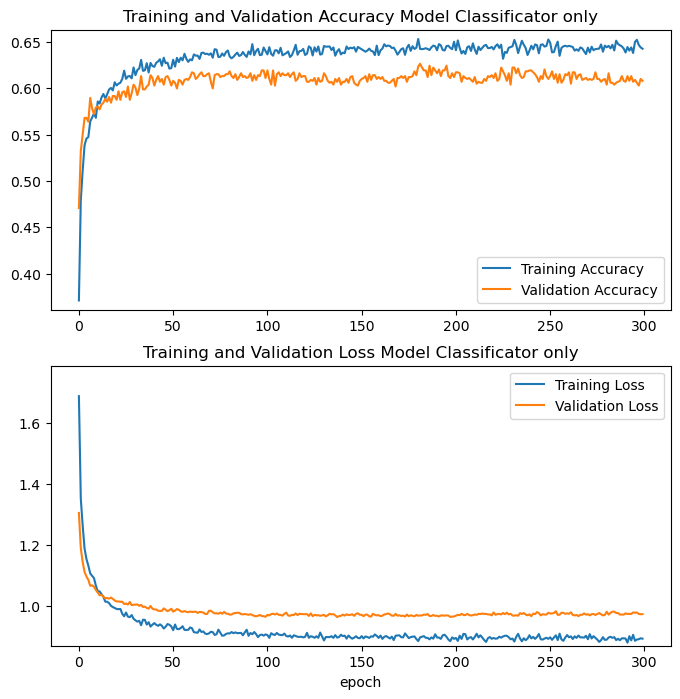

In [7]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Classificator_300['Accuracy'], label='Training Accuracy')
plt.plot(Classificator_300['val_Accuracy'], label='Validation Accuracy')
plt.ylim([alpha-0.01, beta+0.01])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Model Classificator only')

plt.subplot(2, 1, 2)
plt.plot(Classificator_300['loss'], label='Training Loss')
plt.plot(Classificator_300['val_loss'], label='Validation Loss')
plt.ylim([alpha1-0.01, beta1+0.1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Model Classificator only')
plt.xlabel('epoch')
plt.show()

### Fine-tuning 56 layers (from the 50th onwards)

The model has been trained on the top layers classifier for 50 epochs, and then on the 56 layers allowed for fine-tuning for 250 more epochs for a total of 300 epochs.

In [ ]:
alpha = min([min(FineTuned_300['val_Accuracy']),min(FineTuned_300['Accuracy'])])
beta = max([max(FineTuned_300['val_Accuracy']),max(FineTuned_300['Accuracy'])])

alpha1 = min([min(FineTuned_300['loss']),min(FineTuned_300['val_loss'])])
beta1 = max([max(FineTuned_300['loss']),max(FineTuned_300['val_loss'])])

#epoche per cui ho allenato solo lo strato esterno
disc = 50

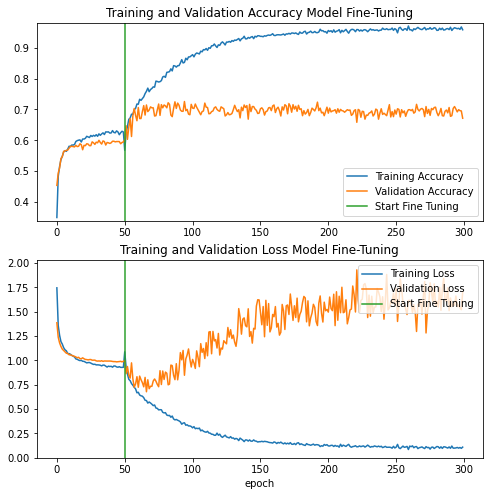

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(FineTuned_300['Accuracy'], label='Training Accuracy')
plt.plot(FineTuned_300['val_Accuracy'], label='Validation Accuracy')
plt.ylim([alpha-0.01, beta+0.01])
plt.plot([disc,disc],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Model Fine-Tuning')

plt.subplot(2, 1, 2)
plt.plot(FineTuned_300['loss'], label='Training Loss')
plt.plot(FineTuned_300['val_loss'], label='Validation Loss')
plt.ylim([0, beta1+0.1])
plt.plot([disc,disc],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Model Fine-Tuning')
plt.xlabel('epoch')
plt.show()

**Note:** On longer training times, the graph clearly shows sign of overfitting as the Training and Validation curves move away from each other.

## Whole net

#### Learning_Rate = 0.0001

In [ ]:
alpha = min([min(Whole_300['val_Accuracy']),min(Whole_300['Accuracy'])])
beta = max([max(Whole_300['val_Accuracy']),max(Whole_300['Accuracy'])])

alpha1 = min([min(Whole_300['loss']),min(Whole_300['val_loss'])])
beta1 = max([max(Whole_300['loss']),max(Whole_300['val_loss'])])


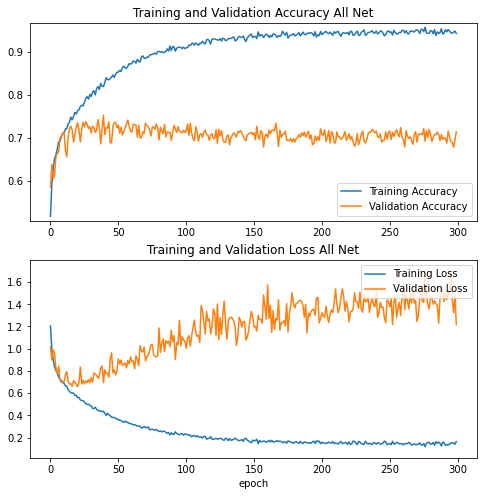

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_300['Accuracy'], label='Training Accuracy')
plt.plot(Whole_300['val_Accuracy'], label='Validation Accuracy')
plt.ylim([alpha-0.01, beta+0.01])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy All Net')

plt.subplot(2, 1, 2)
plt.plot(Whole_300['loss'], label='Training Loss')
plt.plot(Whole_300['val_loss'], label='Validation Loss')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss All Net')
plt.xlabel('epoch')
plt.show()

#### Validation on different Learning Rates (0.0001, 0.001, 0.01)

In [20]:
alpha = min([min(Whole_300['val_Accuracy']),
            min(All_lr_0_01['val_Accuracy']),
             min(All_lr_0_001['val_Accuracy'])])

beta = max([max(Whole_300['val_Accuracy']),
        max(All_lr_0_01['val_Accuracy']),
            max(All_lr_0_001['val_Accuracy'])])

alpha1 = min([min(Whole_300['val_loss']),
             min(All_lr_0_01['val_loss']),
              min(All_lr_0_001['val_loss'])])

beta1 = max([max(Whole_300['val_loss']),
            max(All_lr_0_01['val_loss']),
             max(All_lr_0_001['val_loss'])])

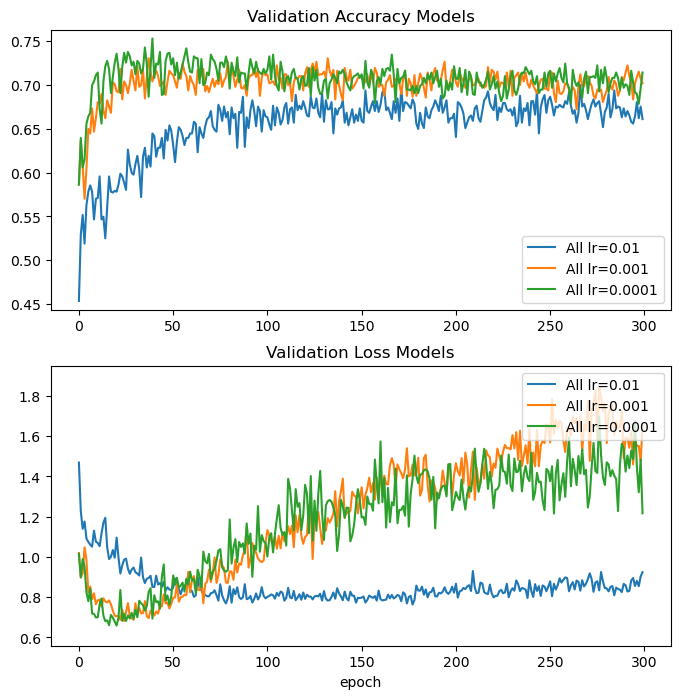

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(All_lr_0_01['val_Accuracy'], label='All lr=0.01')
plt.plot(All_lr_0_001['val_Accuracy'], label='All lr=0.001')
plt.plot(Whole_300['val_Accuracy'], label='All lr=0.0001')
plt.ylim([alpha-0.01, beta+0.01])
plt.legend(loc='lower right')
plt.title('Validation Accuracy Models')

plt.subplot(2, 1, 2)
plt.plot(All_lr_0_01['val_loss'], label='All lr=0.01')
plt.plot(All_lr_0_001['val_loss'], label='All lr=0.001')
plt.plot(Whole_300['val_loss'], label='All lr=0.0001')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.title('Validation Loss Models')
plt.xlabel('epoch')
plt.show()

## Graphs with all models (Training)

Let's compare the 3 models with each other, by plotting them on the same plot.

In [27]:
alpha = min([min(Whole_300['Accuracy']),min(Classificator_300['Accuracy']),min(FineTuned_300['Accuracy'])])
beta = max([max(Whole_300['Accuracy']),max(Classificator_300['Accuracy']),max(FineTuned_300['Accuracy'])])

alpha1 = min([min(Whole_300['loss']),min(Classificator_300['loss']),min(FineTuned_300['loss'])])
beta1 = max([max(Whole_300['loss']),max(Classificator_300['loss']),max(FineTuned_300['loss'])])

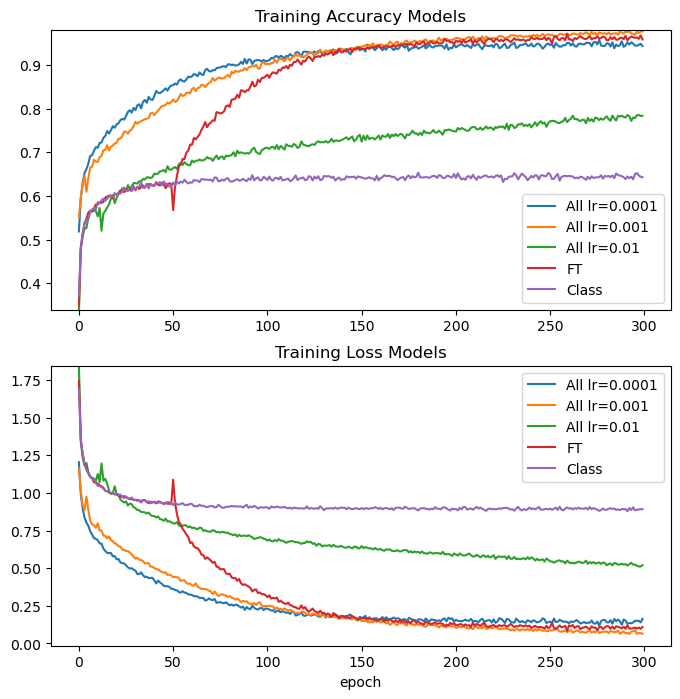

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_300['Accuracy'], label='All lr=0.0001')
plt.plot(All_lr_0_001['Accuracy'], label='All lr=0.001')
plt.plot(All_lr_0_01['Accuracy'], label='All lr=0.01')
plt.plot(FineTuned_300['Accuracy'], label='FT')
plt.plot(Classificator_300['Accuracy'], label='Class')
plt.ylim([alpha-0.01, beta+0.01])
#plt.plot([disc,disc],
#         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy Models')

plt.subplot(2, 1, 2)
plt.plot(Whole_300['loss'], label='All lr=0.0001')
plt.plot(All_lr_0_001['loss'], label='All lr=0.001')
plt.plot(All_lr_0_01['loss'], label='All lr=0.01')
plt.plot(FineTuned_300['loss'], label='FT')
plt.plot(Classificator_300['loss'], label='Class')
plt.ylim([alpha1-0.1, beta1+0.1])
#plt.plot([disc,disc],
#         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss Models')
plt.xlabel('epoch')
plt.show()

## Graphs with all models (Validation)

Let's plot the validation metrics now.

In [30]:
alpha = min([min(Whole_300['val_Accuracy']),min(FineTuned_300['val_Accuracy']),min(Classificator_300['val_Accuracy'])])
beta = max([max(Whole_300['val_Accuracy']),max(FineTuned_300['val_Accuracy']),max(Classificator_300['val_Accuracy'])])

alpha1 = min([min(Whole_300['val_loss']),min(FineTuned_300['val_loss']),min(Classificator_300['val_loss'])])
beta1 = max([max(Whole_300['val_loss']),max(FineTuned_300['val_loss']),max(Classificator_300['val_loss'])])

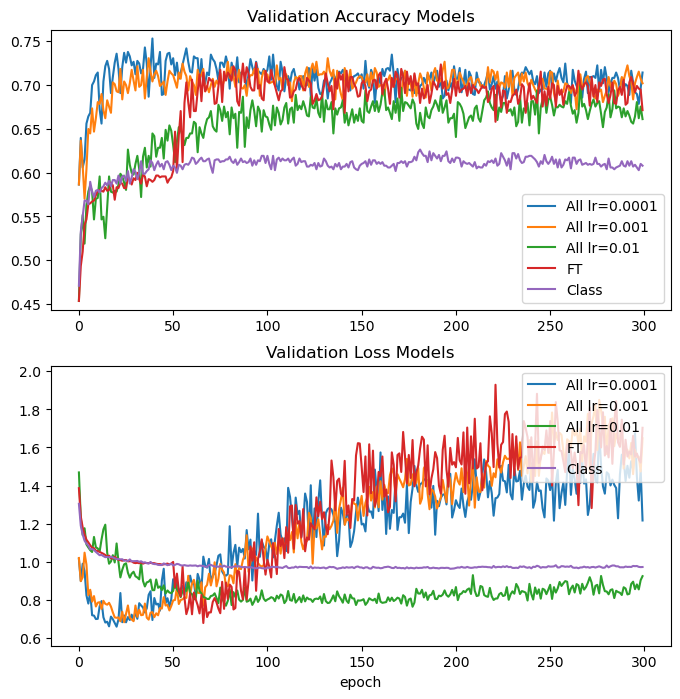

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Whole_300['val_Accuracy'], label='All lr=0.0001')
plt.plot(All_lr_0_001['val_Accuracy'], label='All lr=0.001')
plt.plot(All_lr_0_01['val_Accuracy'], label='All lr=0.01')
plt.plot(FineTuned_300['val_Accuracy'], label='FT')
plt.plot(Classificator_300['val_Accuracy'], label='Class')
plt.ylim([alpha-0.01, beta+0.01])
plt.legend(loc='lower right')
plt.title('Validation Accuracy Models')

plt.subplot(2, 1, 2)
plt.plot(Whole_300['val_loss'], label='All lr=0.0001')
plt.plot(All_lr_0_001['val_loss'], label='All lr=0.001')
plt.plot(All_lr_0_01['val_loss'], label='All lr=0.01')
plt.plot(FineTuned_300['val_loss'], label='FT')
plt.plot(Classificator_300['val_loss'], label='Class')
plt.ylim([alpha1-0.1, beta1+0.1])
plt.legend(loc='upper right')
plt.title('Validation Loss Models')
plt.xlabel('epoch')
plt.show()

## Test performance

This is how all models shown performed on test.

In [19]:
test_acc_FineTuned_300 = pd.read_csv(OUTPUT_TEST+'test_FineTuned_300.csv',delimiter=",")
test_acc_Classificator_300 = pd.read_csv(OUTPUT_TEST+'test_FineTuned_All_300.csv',delimiter=",")
test_acc_all_300 = pd.read_csv(OUTPUT_TEST+'test_all_300.csv',delimiter=",")
test_acc_FineTuned_20 = pd.read_csv(OUTPUT_TEST+'test_FineTuned_20.csv',delimiter=",")
test_acc_all_20 = pd.read_csv(OUTPUT_TEST+'test_all_20.csv',delimiter=",")
test_acc_classificator_20 = pd.read_csv(OUTPUT_TEST+'test_classificatore_20.csv',delimiter=",")

## 20 epochs

In [ ]:
print("Test accuracy Top classificator",test_acc_classificator_20['0'][2])
print("Test accuracy Fine tuned model",test_acc_FineTuned_20['0'][2])
print("Test accuracy training on all net",test_acc_all_20['0'][2])

Test accuracy Top classificator 0.6190993189811707
Test accuracy Fine tuned model 0.7151383757591248
Test accuracy training on all net 0.7645143866539001


## 300 epochs

In [18]:
print("Test accuracy Top classificator",test_acc_Classificator_300['0'][2])
print("Test accuracy Fine tuned model",test_acc_FineTuned_300['0'][2])
print("Test accuracy training on all net",test_acc_all_300['0'][2])

Test accuracy Top classificator 0.6018424034118652
Test accuracy Fine tuned model 0.6898669600486755
Test accuracy training on all net 0.7031729817390442


**Conclusions:** Training the whole network provides best accuracy; for fixed training time, the whole network is also more accurate.